**Importing the Dependencies**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [ ]:
# conver the zip folder into files
from zipfile import ZipFile
data="/content/potato.zip"

with ZipFile(data,"r") as zip:
  zip.extractall()
  print("the datset is extracted")

the datset is extracted


In [ ]:
# load the data
import tensorflow as tf
CHANNEL=3
IMG_SIZE=256
BATCH_SIZE=32
EPOCHS=20
data=tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/Potato/Train',
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE)

)

Found 900 files belonging to 3 classes.


In [ ]:
len(data)

29

In [ ]:
data.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
data.class_names[0]

'Potato___Early_blight'

In [ ]:
for img_size,label_size in data.take(1):
  print("batch_size",img_size.shape)
  print("labels size",label_size.numpy())
  print("labels shape",label_size.shape)
  print("firts img",img_size[0])

batch_size (32, 256, 256, 3)
labels size [2 1 0 1 2 0 0 0 0 1 2 2 0 1 0 2 0 0 0 0 2 2 1 2 0 0 1 1 0 2 1 2]
labels shape (32,)
firts img tf.Tensor(
[[[179. 173. 183.]
  [179. 173. 183.]
  [179. 171. 182.]
  ...
  [199. 189. 200.]
  [193. 183. 194.]
  [192. 182. 193.]]

 [[179. 173. 183.]
  [179. 173. 183.]
  [179. 171. 182.]
  ...
  [199. 189. 200.]
  [191. 181. 192.]
  [183. 173. 184.]]

 [[179. 173. 183.]
  [179. 173. 183.]
  [179. 171. 182.]
  ...
  [195. 185. 196.]
  [193. 183. 194.]
  [190. 180. 191.]]

 ...

 [[171. 158. 165.]
  [168. 155. 162.]
  [170. 157. 164.]
  ...
  [155. 136. 142.]
  [157. 138. 144.]
  [169. 150. 156.]]

 [[173. 160. 167.]
  [170. 157. 164.]
  [173. 160. 167.]
  ...
  [158. 139. 145.]
  [157. 138. 144.]
  [171. 152. 158.]]

 [[180. 167. 174.]
  [176. 163. 170.]
  [177. 164. 171.]
  ...
  [149. 130. 136.]
  [153. 134. 140.]
  [176. 157. 163.]]], shape=(256, 256, 3), dtype=float32)


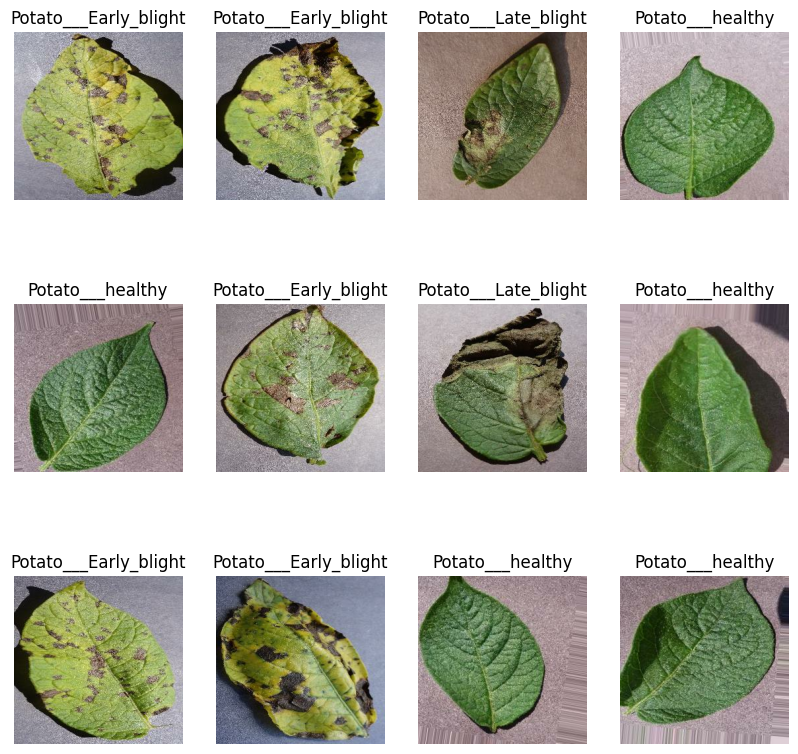

In [ ]:
# visulaze the images
plt.figure(figsize=(10,10))
for img_size,label_size in data.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(img_size[i].numpy().astype('uint8'))
    plt.title(data.class_names[label_size[i]])
    plt.axis("off")

**Split the data into train,test,val**

In [ ]:
def get_data_as_partition_tf(df,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size=len(df)

  if shuffle:
    df=df.shuffle(shuffle_size,seed=123)

    train_size=int(train_split*len(df))
    val_size=int(val_split*len(df))

    train_data=df.take(train_size)
    val_data=df.skip(train_size).take(val_size)
    test_data=df.skip(train_size).skip(val_size)

    return train_data,val_data,test_data

train_data,val_data,test_data=get_data_as_partition_tf(data)

In [ ]:
len(train_data)

23

In [ ]:
len(val_data)

2

In [ ]:
len(test_data)

4

In [ ]:
# cache,shuffle,prefetch for model training efficiency

train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_data)

23

**Rescale and Resize**

In [ ]:
rescale_and_resize=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

**Data Augumentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Random rotation by up to 20%
    tf.keras.layers.RandomZoom(0.2),  # Random zooming (zoom in or out)
    tf.keras.layers.RandomWidth(0.2),  # Random width shift
    tf.keras.layers.RandomHeight(0.2),  # Random height shift
    tf.keras.layers.RandomContrast(0.2),  # Random contrast adjustment
    tf.keras.layers.RandomBrightness(0.2)  # Random brightness adjustment
])


In [ ]:
# applying data augumentatio to the train data
train_data=train_data.map(lambda x,y:(data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(train_data)

23

**Model Building**

In [ ]:
# input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL)

num_of_classes = 3

model = tf.keras.Sequential([

    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL)),
    rescale_and_resize,# Fix input_shape
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_of_classes, activation="softmax")
])

# Since input_shape is already defined, no need to call model.build


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 126, 126, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history=model.fit(train_data,batch_size=BATCH_SIZE,validation_data=val_data,verbose=1,epochs=20)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.4368 - loss: 1.1158 - val_accuracy: 0.6719 - val_loss: 0.6695
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6681 - loss: 0.7570 - val_accuracy: 0.7656 - val_loss: 0.5613
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7512 - loss: 0.5131 - val_accuracy: 0.8438 - val_loss: 0.3797
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7825 - loss: 0.5021 - val_accuracy: 0.8125 - val_loss: 0.4336
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8747 - loss: 0.3287 - val_accuracy: 0.8906 - val_loss: 0.2514
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8542 - loss: 0.3447 - val_accuracy: 0.8125 - val_loss: 0.4897
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8807 - loss: 0.2828 - val_accuracy: 0.9219 - val_loss: 0.1852
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9019 - loss: 0.2516 - val_accuracy: 0.8594 - val_loss:

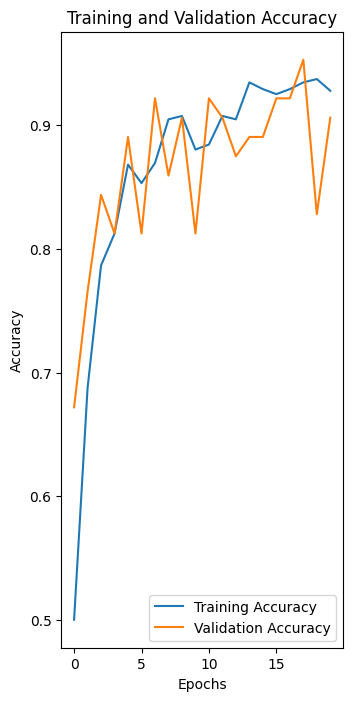

In [ ]:

# Extract training and validation accuracy from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

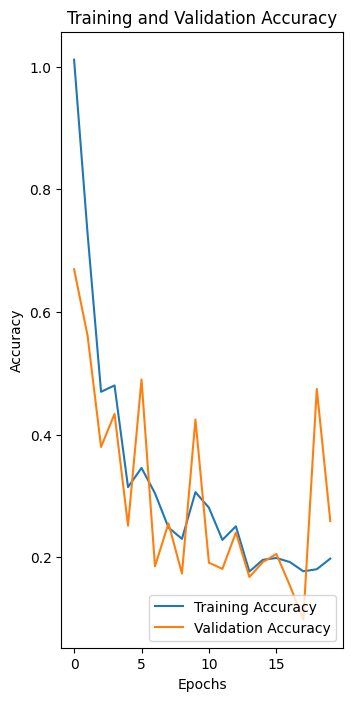

In [ ]:
# Extract training and validation accuracy from the history
loss = history.history['loss']
val_loss= history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**Predict one data image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
actual label: Potato___healthy
predicted label: Potato___healthy


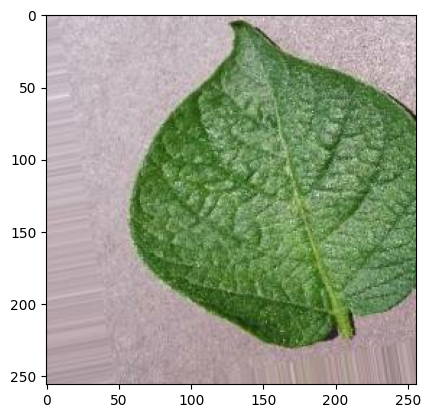

In [ ]:
for img_size,label_size in test_data.take(1):
  first_img=img_size[0].numpy().astype('uint8')
  label=label_size[0].numpy()


  plt.imshow(first_img)
  prediction=model.predict(img_size)

  print("actual label:",data.class_names[label])

  print("predicted label:",data.class_names[np.argmax(prediction[0])])


**Write a function to predict some more images**

In [ ]:
def make_predictin(model, image):
    # Convert the image to an array
    img = tf.keras.preprocessing.image.img_to_array(image)

    # Add a batch dimension to the image (necessary for model prediction)
    img_array = np.expand_dims(img, axis=0)

    # Make prediction on the image
    prediction = model.predict(img_array)

    # Get the predicted class name from class_names
    predicted_class = data.class_names[np.argmax(prediction[0])]

    # Get the confidence (highest probability) of the prediction
    confidence = round(100 * np.max(prediction[0]), 2)

    return predicted_class, confidence



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


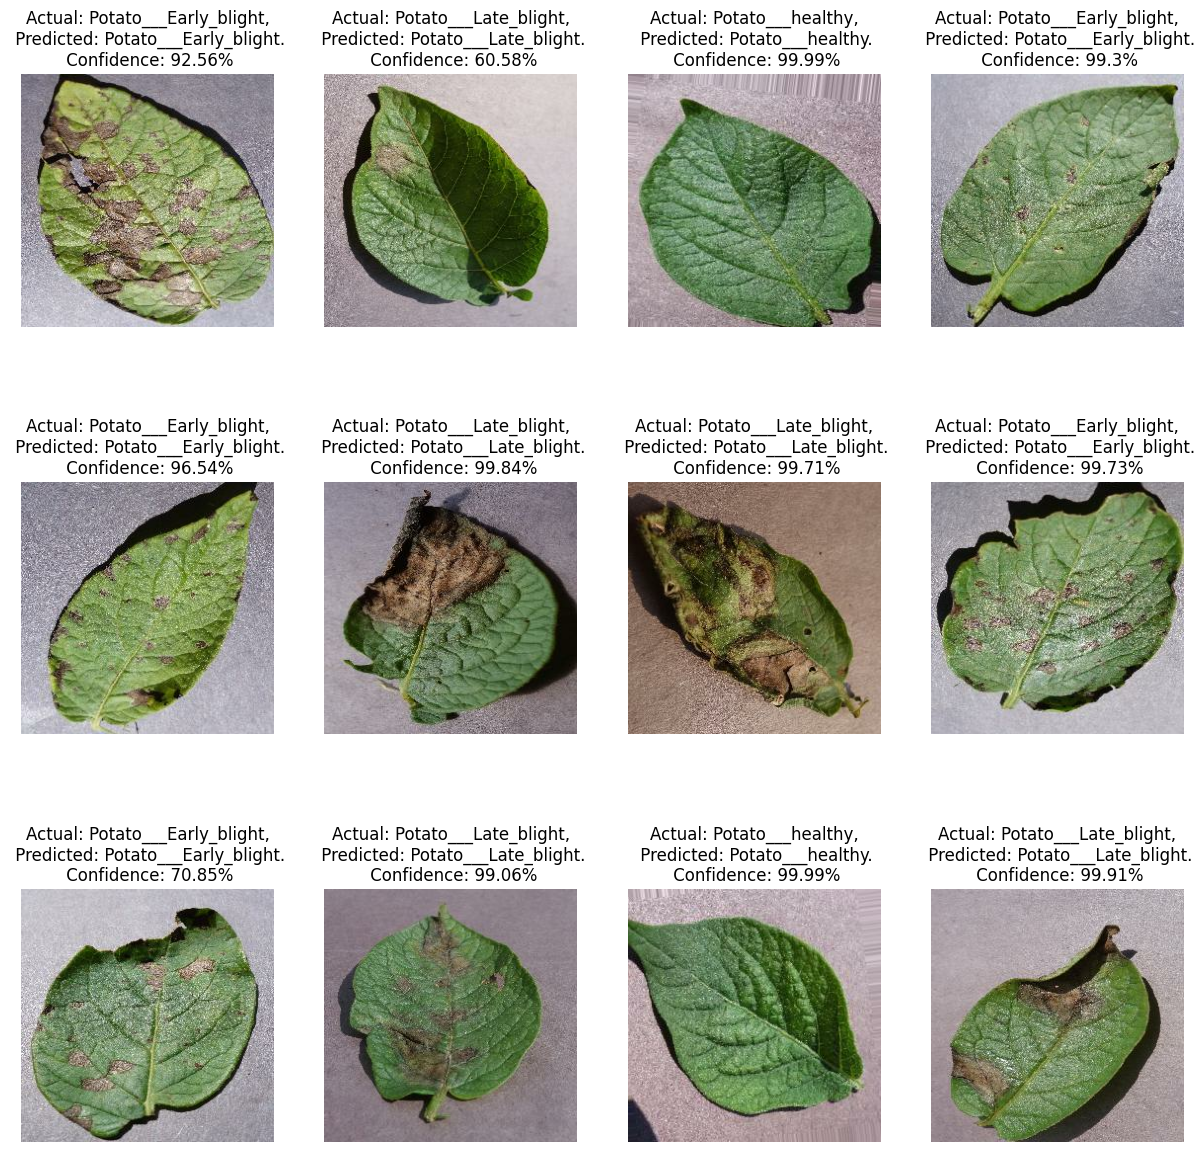

In [ ]:
plt.figure(figsize=(15, 15))
for img_size, label_size in test_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)

        # Convert image to numpy array for plotting
        img = img_size[i].numpy().astype("uint8")
        plt.imshow(img)

        # Make prediction for the current image
        predicted_class, confidence = make_predictin(model, img_size[i])

        # Get the actual class name from the label
        actual_class = data.class_names[label_size[i]]

        # Set the title with actual class, predicted class, and confidence
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        # Turn off axis
        plt.axis("off")

plt.show()


In [ ]:
model.save("model.h5")

In [ ]:
img[0].shape

(256, 3)